# 장애인 콜택시 대기시간 예측 프로젝트 데이터 처리
## 목표
- 기상 예보를 바탕으로, 장애인 콜택시 평균 대기 시간을 예측하기.
- 장애인 이동권 개선을 위하여서, 콜택시 대기시간을 예측하는 프로젝트이다.  
- 이를 통하여 장애인 콜택시를 이용하는 고객들의 불편사항을 개선하고 서비스의 품질을 높여 교통약자의 이동 편의 증진에 기여한다.
### 목차
1. 데이터 처리  
2. 데이터 분석
3. **머신러닝 모델링**   
    - (나머지 3달 데이터는 테스트, 나머지는 학습데이터로 활용)  
    - MAE, MAPE를 사용해 성능 높은 모델 선정  
- 데이터 출처 : [서울시설공단_장애인콜택시 일별 이용현황](https://www.data.go.kr/data/15057705/openapi.do)  

## 라이브러리 불러오기

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# 회귀 모델
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 회귀 성능 튜닝
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# 회귀 평가
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score

# 딥러닝
import tensorflow as tf

import warnings
warnings.filterwarnings(action='ignore') # pd 경고메시지 생략

## 데이터 불러오기

In [2]:
# df = pd.read_csv('./data/df.csv')
df = joblib.load('./data/df.pkl')
df.head()

,car_cnt,request_cnt,ride_cnt,waiting_time,fare,distance,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),year,month,week,weekday,holiday,7days_waiting_time
time,,,,,,,,,,,,,,,,,,
2015-01-01,213,1023,924,23.2,2427,10764,-2.0,-8.9,0.0,63.0,28.0,9.07,2015,1,1,3,1.0,NaN
2015-01-02,420,3158,2839,17.2,2216,8611,2.4,-9.2,0.0,73.0,37.0,8.66,2015,1,1,4,0.0,NaN
2015-01-03,209,1648,1514,26.2,2377,10198,8.2,0.2,0.0,89.0,58.0,5.32,2015,1,1,5,1.0,NaN
2015-01-04,196,1646,1526,24.5,2431,10955,7.9,-0.9,0.0,95.0,52.0,6.48,2015,1,1,6,1.0,NaN
2015-01-05,421,4250,3730,26.2,2214,8663,4.1,-7.4,3.4,98.0,29.0,10.47,2015,1,2,0,0.0,NaN


#### NaN 값 처리, 타입 변경하기

In [3]:
drop_col = '7days_waiting_time'
df = df.drop(drop_col, axis=1)

In [4]:
df['weekday'] = df['weekday'].astype('int') # 해당 코드 진행시 변경이 안됌

In [5]:
df = df.astype('float')

In [6]:
df

,car_cnt,request_cnt,ride_cnt,waiting_time,fare,distance,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),year,month,week,weekday,holiday
time,,,,,,,,,,,,,,,,,
2015-01-01,213.0,1023.0,924.0,23.2,2427.0,10764.0,-2.0,-8.9,0.0,63.0,28.0,9.07,2015.0,1.0,1.0,3.0,1.0
2015-01-02,420.0,3158.0,2839.0,17.2,2216.0,8611.0,2.4,-9.2,0.0,73.0,37.0,8.66,2015.0,1.0,1.0,4.0,0.0
2015-01-03,209.0,1648.0,1514.0,26.2,2377.0,10198.0,8.2,0.2,0.0,89.0,58.0,5.32,2015.0,1.0,1.0,5.0,1.0
2015-01-04,196.0,1646.0,1526.0,24.5,2431.0,10955.0,7.9,-0.9,0.0,95.0,52.0,6.48,2015.0,1.0,1.0,6.0,1.0
2015-01-05,421.0,4250.0,3730.0,26.2,2214.0,8663.0,4.1,-7.4,3.4,98.0,29.0,10.47,2015.0,1.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,669.0,5635.0,4654.0,44.4,2198.0,8178.0,-0.3,-5.4,0.1,92.0,40.0,10.86,2022.0,12.0,52.0,1.0,0.0
2022-12-28,607.0,5654.0,4648.0,44.8,2161.0,7882.0,1.7,-7.8,0.0,71.0,34.0,10.88,2022.0,12.0,52.0,2.0,0.0
2022-12-29,581.0,5250.0,4247.0,52.5,2229.0,8433.0,2.1,-4.0,0.0,87.0,38.0,10.84,2022.0,12.0,52.0,3.0,0.0


# 데이터 나누기
* 시계열 데이터 특성에 맞게 분할  
* 마지막 91일(3개월) 데이터를 검증셋으로 사용

#### x,y 분리하기

In [7]:
target = 'waiting_time'

x = df.drop(target, axis=1)
y = df.loc[:,target]

In [32]:
display(x.head(2))
display(y.head(2))

,car_cnt,request_cnt,ride_cnt,fare,distance,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),year,month,week,weekday,holiday
time,,,,,,,,,,,,,,,,
2015-01-01,213.0,1023.0,924.0,2427.0,10764.0,-2.0,-8.9,0.0,63.0,28.0,9.07,2015.0,1.0,1.0,3.0,1.0
2015-01-02,420.0,3158.0,2839.0,2216.0,8611.0,2.4,-9.2,0.0,73.0,37.0,8.66,2015.0,1.0,1.0,4.0,0.0


time
2015-01-01    23.2
2015-01-02    17.2
Name: waiting_time, dtype: float64

In [9]:
y.head(2)

time
2015-01-01    23.2
2015-01-02    17.2
Name: waiting_time, dtype: float64

#### train, validation 나누기

In [10]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size= 92, shuffle=False)

#### 정규화
- knn 사용을 위해서

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(x_train)
x_train_s = scaler.transform(x_train)
x_test_s = scaler.transform(x_train)

# 데이터 모델링

- MAE, MAPE로 성능 측정
- MAE와 MAPE는 모두 값이 작을수록 모델의 성능이 좋다는 것을 의미한다.

## ML

#### ML모델 선언

In [29]:
LR_model = LinearRegression()
KN_model = KNeighborsRegressor()
Tree_model = DecisionTreeRegressor()
RanF_model = RandomForestRegressor()
xg_model = XGBRegressor()
lg_model = LGBMRegressor()

models = {'LR_model':LR_model,
        'KN_model':KN_model,
        'Tree_model':Tree_model,
        'RanF_model':RanF_model,
        'xg_model':xg_model,
        'lg_model':lg_model}

In [34]:
m = LR_model.fit(x_train, y_train)
y_pred = m.predict(x_test)


#### 모델 학습 및 평가

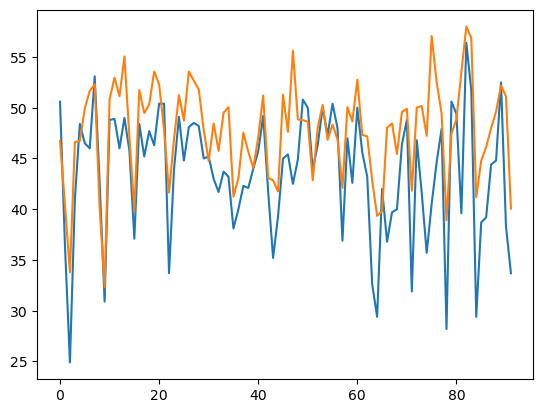

LR_model
MAE: 4.610387378195424
MAPE: 0.1162958967265707
MAPE: 0.10414880707422336


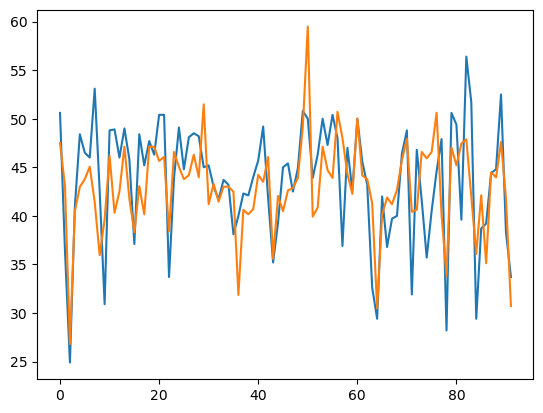

KN_model
MAE: 3.8902173913043474
MAPE: 0.09224329725907993
MAPE: 0.37802421063301406


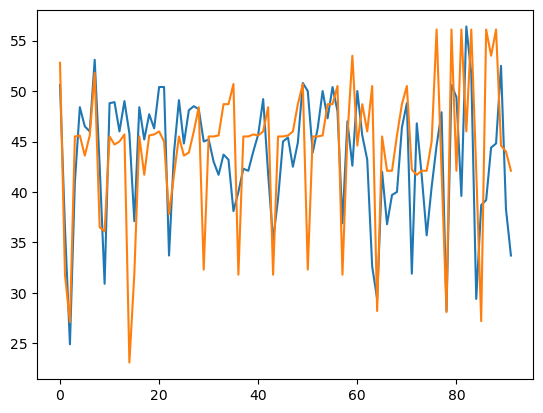

Tree_model
MAE: 5.065217391304347
MAPE: 0.12170950309407728
MAPE: -0.228537580457149


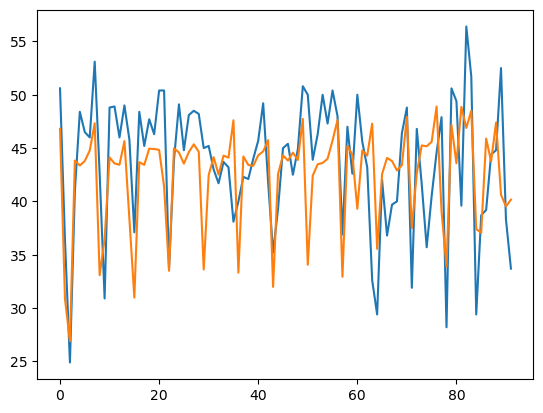

RanF_model
MAE: 4.240173913043479
MAPE: 0.10056224590556162
MAPE: 0.2339786831888907


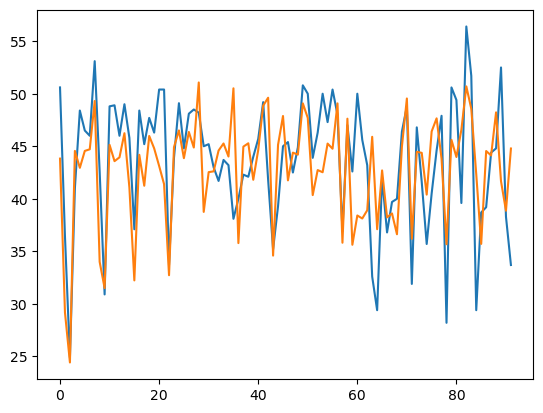

xg_model
MAE: 3.978145848149839
MAPE: 0.09523714185397465
MAPE: 0.3217762417917668
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2395
[LightGBM] [Info] Number of data points in the train set: 2831, number of used features: 16
[LightGBM] [Info] Start training from score 40.192794


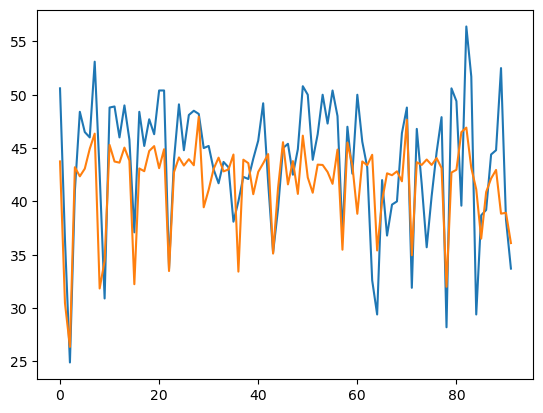

lg_model
MAE: 3.98069572960794
MAPE: 0.0922415968802517
MAPE: 0.33956601720963075


In [49]:
results = []
for name, model in models.items():
    print("="*50)
    if model != 'KN_model':
        model.fit(x_train, y_train) # 모델 학습
        y_pred = model.predict(x_test) # 모델 예측
        model_mae = mae(y_test, y_pred)
        model_mape = mape(y_test, y_pred)
        model_r2 = r2_score(y_test, y_pred)
    else:
        model.fit(x_train_s, y_train)
        y_pred = model.predict(x_test_s)
        model_mae = mae(y_test, y_pred)
        model_mape = mape(y_test, y_pred)
        model_r2 = r2_score(y_test, y_pred)
        
    plt.plot(np.array(y_test))
    plt.plot(y_pred)
    plt.show()
    print(name)
    print('MAE:', model_mae)
    print('MAPE:', model_mape)
    print('MAPE:', model_r2)
    
    results.append([name, (model_mae, model_mape, model_r2)])

In [31]:
sorted(results, key=lambda x: x[1][1])

[['lg_model', (3.98069572960794, 0.0922415968802517, 0.33956601720963075)],
 ['KN_model', (3.8902173913043474, 0.09224329725907993, 0.37802421063301406)],
 ['xg_model', (3.978145848149839, 0.09523714185397465, 0.3217762417917668)],
 ['RanF_model', (4.09971739130435, 0.09782876003424804, 0.2804674929299078)],
 ['LR_model', (4.610387378195424, 0.1162958967265707, 0.10414880707422336)],
 ['Tree_model', (5.234782608695652, 0.12586299198622147, -0.3536148700015209)]]

#### 모델 튜닝
- 해당부분, 공유를 통하여 문제 해결하면 좋을것 같다는 생각함

##### KNN 모델

In [15]:
# 파라미터 선언
param = {'n_neighbors': range(1, 500, 10),
        'metric': ['euclidean', 'manhattan']}

# Random Search 선언
model = GridSearchCV(KN_model,
                            param,
                            cv=3)
# 학습하기
model.fit(x_train_s, y_train)

# 중요 정보 확인
print('=' * 80)
print(model.cv_results_['mean_test_score'])
print('-' * 80)
print('최적파라미터:', model.best_params_)
print('-' * 80)
print('최고성능:', model.best_score_)
print('=' * 80)

# 예측하기
y_pred = model.predict(x_test_s)

[-3.14988452 -3.18536883 -3.46703641 -3.61230397 -3.70458865 -3.74456733
 -3.7486516  -3.723864   -3.67738877 -3.62084598 -3.55800847 -3.49590346
 -3.43069401 -3.36634818 -3.30057635 -3.24235023 -3.18123512 -3.12149263
 -3.06064392 -3.00397011 -2.94840821 -2.89441697 -2.84148898 -2.79138789
 -2.74537039 -2.69966628 -2.65764882 -2.61821801 -2.5790347  -2.54110399
 -2.50606638 -2.47292527 -2.44042741 -2.41058186 -2.38279703 -2.35482432
 -2.32820748 -2.30489614 -2.28029142 -2.2557219  -2.23269278 -2.21197734
 -2.19245371 -2.17183756 -2.15343715 -2.13543591 -2.11817711 -2.10290511
 -2.08770339 -2.07342732 -3.55904648 -3.140117   -3.12031796 -3.04132157
 -2.96787061 -2.9018036  -2.81843166 -2.74037966 -2.66247947 -2.59810798
 -2.53725702 -2.47534893 -2.42215312 -2.37245626 -2.32669448 -2.28460295
 -2.24631741 -2.21448749 -2.18136489 -2.15284148 -2.1262737  -2.10388417
 -2.0814092  -2.06271093 -2.04392406 -2.02824833 -2.01437812 -2.00164559
 -1.98920232 -1.97722125 -1.96871448 -1.96062007 -1

##### RandomForest 모델

In [16]:
# 파라미터 선언
# max_depth: 1~50
param = {'max_depth': range(1,51)}

# Random Search 선언
  # cv=5
  # n_iter=20
  # scoring='r2'
model = RandomizedSearchCV(RanF_model, # 기본 모델
                          param,       # 파라미터 범위
                          cv=5,        # K-Folde 개수
                          n_iter=20   # 랜덤하게 선택할 파라미터(조합) 개수
                          )
# 학습하기
model.fit(x_train, y_train)

# 중요 정보 확인
print('=' * 80)
print(model.cv_results_['mean_test_score'])
print('-' * 80)
print('최적파라미터:', model.best_params_)
print('-' * 80)
print('최고성능:', model.best_score_)
print('=' * 80)

# 예측하기
y_pred = model.predict(x_test)

print('MAE:', mae(y_test, y_pred))
print('MAPE:', mape(y_test, y_pred))

[ 1.21839709e-02 -5.03225652e-03 -1.61350456e-02  2.35743681e-04
 -6.29415276e-02  1.13144925e-02 -1.48350616e-02  1.98390341e-02
 -1.68160982e-01 -4.10371641e-02  8.21651399e-03 -2.16048650e-02
 -2.60986282e-01 -8.71747483e-03  2.37265429e-02 -1.12685587e+00
 -8.06493955e-03 -1.65734334e-02 -5.62521819e-03 -3.75709022e-02]
--------------------------------------------------------------------------------
최적파라미터: {'max_depth': 40}
--------------------------------------------------------------------------------
최고성능: 0.023726542861216206
MAE: 4.0247282608695665
MAPE: 0.09558828327094401


##### Decision Tree 모델

In [17]:
# 파라미터 선언
# max_depth: 1~50
param = {'max_depth': range(1,51)}

model = RandomizedSearchCV(Tree_model, # 기본 모델
                          param,       # 파라미터 범위
                          cv=5,        # K-Folde 개수
                          n_iter=20   # 랜덤하게 선택할 파라미터(조합) 개수
                          )
# 학습하기
model.fit(x_train, y_train)

# 중요 정보 확인
print('=' * 80)
print(model.cv_results_['mean_test_score'])
print('-' * 80)
print('최적파라미터:', model.best_params_)
print('-' * 80)
print('최고성능:', model.best_score_)
print('=' * 80)

# 예측하기
y_pred = model.predict(x_test)

print('MAE:', mae(y_test, y_pred))
print('MAPE:', mape(y_test, y_pred))

[-0.27393305 -0.30438806 -0.30400268 -0.56472415 -0.30217389 -0.61511703
 -0.2049566  -0.26303765 -0.21463696 -0.76868306 -0.95392719 -0.29957821
 -0.29951888 -0.26947937 -0.22619379 -0.45538384 -0.32840409 -0.34213802
 -0.29285456 -0.26562699]
--------------------------------------------------------------------------------
최적파라미터: {'max_depth': 18}
--------------------------------------------------------------------------------
최고성능: -0.20495660392450626
MAE: 5.378260869565217
MAPE: 0.12860705161471067


## DeapLearning

In [51]:
print(f"X shape : {x.shape}")
print(f"Y shape : {y.shape}")

X shape : (2923, 16)
Y shape : (2923,)


#### 모델 구조 생성

In [56]:
X = tf.keras.Input(shape=[16])

H = tf.keras.layers.Dense(2048)(X) 
H = tf.keras.layers.BatchNormalization()(H) 
H = tf.keras.layers.Activation('swish')(H)

H = tf.keras.layers.Dense(512)(H) 
H = tf.keras.layers.BatchNormalization()(H) 
H = tf.keras.layers.Activation('swish')(H)

# 여기 부분이 skip connection 레이어층 쌓기 부분
for i in range(32):
    H1 = tf.keras.layers.Dense(512)(H)
    H1 = tf.keras.layers.BatchNormalization()(H1)
    H = tf.keras.layers.Add()([H,H1])
    H = tf.keras.layers.Activation("swish")(H)

Y = tf.keras.layers.Dense(1, activation="linear")(H)

dp_model = tf.keras.Model(X, Y)
dp_model.compile(loss=tf.keras.losses.mse, 
                 metrics=tf.keras.metrics.mae,
                optimizer=tf.keras.optimizers.Adam())
dp_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 16)]                 0         []                            
                                                                                                  
 dense_140 (Dense)           (None, 2048)                 34816     ['input_5[0][0]']             
                                                                                                  
 batch_normalization_136 (B  (None, 2048)                 8192      ['dense_140[0][0]']           
 atchNormalization)                                                                               
                                                                                                  
 activation_136 (Activation  (None, 2048)                 0         ['batch_normalization_13

 batch_normalization_143 (B  (None, 512)                  2048      ['dense_147[0][0]']           
 atchNormalization)                                                                               
                                                                                                  
 add_133 (Add)               (None, 512)                  0         ['activation_142[0][0]',      
                                                                     'batch_normalization_143[0][0
                                                                    ]']                           
                                                                                                  
 activation_143 (Activation  (None, 512)                  0         ['add_133[0][0]']             
 )                                                                                                
                                                                                                  
 dense_148

                                                                                                  
 batch_normalization_150 (B  (None, 512)                  2048      ['dense_154[0][0]']           
 atchNormalization)                                                                               
                                                                                                  
 add_140 (Add)               (None, 512)                  0         ['activation_149[0][0]',      
                                                                     'batch_normalization_150[0][0
                                                                    ]']                           
                                                                                                  
 activation_150 (Activation  (None, 512)                  0         ['add_140[0][0]']             
 )                                                                                                
          

 dense_161 (Dense)           (None, 512)                  262656    ['activation_156[0][0]']      
                                                                                                  
 batch_normalization_157 (B  (None, 512)                  2048      ['dense_161[0][0]']           
 atchNormalization)                                                                               
                                                                                                  
 add_147 (Add)               (None, 512)                  0         ['activation_156[0][0]',      
                                                                     'batch_normalization_157[0][0
                                                                    ]']                           
                                                                                                  
 activation_157 (Activation  (None, 512)                  0         ['add_147[0][0]']             
 )        

                                                                                                  
 dense_168 (Dense)           (None, 512)                  262656    ['activation_163[0][0]']      
                                                                                                  
 batch_normalization_164 (B  (None, 512)                  2048      ['dense_168[0][0]']           
 atchNormalization)                                                                               
                                                                                                  
 add_154 (Add)               (None, 512)                  0         ['activation_163[0][0]',      
                                                                     'batch_normalization_164[0][0
                                                                    ]']                           
                                                                                                  
 activatio

#### 오버피팅 방지 및 모델 학습

In [55]:
# 콜백함수 만들기
early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                        min_delta = 0, # 이보다 작게 변하면 변한다고 안할거임.
                                        patience = 10, # 이 회수(epoch)동안 개선이 없으면 끝냄
                                        restore_best_weights=True)
# 모델 학습
result = dp_model.fit(x_train, y_train, epochs=1000, batch_size=128, validation_split=0.2, callbacks=[early])

Epoch 1/1000
18/18 [==============================] - 16s 260ms/step - loss: 26.9649 - mean_absolute_error: 26.9649 - val_loss: 34.0342 - val_mean_absolute_error: 34.0342
Epoch 2/1000
18/18 [==============================] - 4s 203ms/step - loss: 11.2824 - mean_absolute_error: 11.2824 - val_loss: 34.0342 - val_mean_absolute_error: 34.0342
Epoch 3/1000
18/18 [==============================] - 4s 213ms/step - loss: 8.5915 - mean_absolute_error: 8.5915 - val_loss: 34.0342 - val_mean_absolute_error: 34.0342
Epoch 4/1000
18/18 [==============================] - 4s 227ms/step - loss: 9.6316 - mean_absolute_error: 9.6316 - val_loss: 34.0342 - val_mean_absolute_error: 34.0342
Epoch 5/1000
18/18 [==============================] - 4s 214ms/step - loss: 7.5613 - mean_absolute_error: 7.5613 - val_loss: 34.0342 - val_mean_absolute_error: 34.0342
Epoch 6/1000
18/18 [==============================] - 4s 220ms/step - loss: 7.0262 - mean_absolute_error: 7.0262 - val_loss: 33.8262 - val_mean_absolute_er

KeyboardInterrupt: 

In [ ]:
# 모델 평가하기
dp_model.evaluate(x_test, y_test)

In [ ]:
# 예측하기
y_pred = dp_model.predict(x_test)

print('MAE:', mae(y_test, y_pred))
print('MAPE:', mape(y_test, y_pred))
print('r2_score:', r2_score(y_test, y_pred))

In [ ]:
len(y_test)

In [ ]:
len(y_pred)

In [ ]:
plt.plot(np.array(y_test))
plt.plot(y_pred)
plt.show()